## Was Messi the best dribbler at World Cup 2018?

In [1]:
import os
import pandas as pd
import numpy as np
import math
import json

# Counter's useful for creating quick histogram counts of things (e.g. like event types within Statsbomb data)
from collections import Counter

# plotting libraries
from mplsoccer.pitch import Pitch, add_image
from mplsoccer.statsbomb import read_event, read_lineup, EVENT_SLUG, LINEUP_SLUG
import matplotlib.pyplot as plt

# pprint helps to look at JSON hierarchies
import pprint as pp

pd.set_option('display.max_rows', 500)

### Repos

In [2]:
statsbomb_repo = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Football/Data/Statsbomb/open-data-master/data'
statsbomb_data = os.listdir(statsbomb_repo)

### Helper Functions

In [3]:
def event_lookup(lst_events, Id):
    return [j for i in lst_events for j in i if j.get('id') == Id][0]

def carry_dribble_mapping(lst_events, player):
    """
    Facinating - a dribble may link to multiple carries
    Carries can happen before and after a take-on
    So we can plot where the player was for the take on, and where the first carry started, and the second carry finished
    """
    
    # getting all carries from list of all events
    carries = [j for i in lst_events for j in i if j.get('type').get('name') == 'Carry']
    
    # filtering all carries so we're just looking at carries performed by a specific player (quickens up the next bit)
    player_carries = [i for i in carries if i.get('player').get('name') == player]
    
    # columns for final dataframe
    carry_cols = ['dribbleId','carryId','dribble_start_x','dribble_start_y','dribble_end_x','dribble_end_y','dribble_duration']
    
    # nested list comprehension to map carries to dribbles
    dribble_mapping = [[j, i.get('id'),i.get('location')[0],i.get('location')[1],i.get('carry').get('end_location')[0],i.get('carry').get('end_location')[1],i.get('duration')] for i in player_carries for j in i.get('related_events') if event_lookup(lst_events, j).get('type').get('name') == 'Dribble']
    
    # outputting mapping table
    return pd.DataFrame(dribble_mapping, columns=carry_cols)

### Elo Attack / Elo Defence Functions

In [4]:
def expected_win(r1, r2):
    """
    Expected probability of player 1 beating player 2
    if player 1 has rating 1 (r1) and player 2 has rating 2 (r2)
    """
    return 1.0 / (1 + math.pow(10, (r2-r1)/400))

def update_rating(R, k, P, d):
    """
    d = 1 = WIN
    d = 0 = LOSS
    """
    return R + k*(d-P)

In [5]:
def elo(Ra, Rb, k, d):
    """
    d = 1 when player A wins
    d = 0 when player B wins
    """
    
    Pa = expected_win(Ra, Rb)
    Pb = expected_win(Rb, Ra)
    
    # update if A wins
    if d == 1:
        Ra = update_rating(Ra, k, Pa, d)
        Rb = update_rating(Rb, k, Pb, d-1)
    
    # update if B wins
    elif d == 0:
        Ra = update_rating(Ra, k, Pa, d)
        Rb = update_rating(Rb, k, Pb, d+1)
    
    return Pa, Pb, Ra, Rb

In [6]:
def elo_attack_defence_sequence(things, initial_rating, k, results):
    """
    Initialises score dictionaries for attack and defence, and runs through sequence of pairwise results, returning final dictionaries with Elo rankings for both attack (dribblers) and defence (of dribblers)
    """

    dic_scores_attack = {i:initial_rating for i in things}
    dic_scores_defence = {i:initial_rating for i in things}

    for result in results:

        winner, loser, dribble_outcome = result
        
        # winner = attacker, loser = defender
        if dribble_outcome == 1:
            Ra, Rb = dic_scores_attack[winner], dic_scores_defence[loser]
            _, _, newRa, newRb = elo(Ra, Rb, k, 1)
            dic_scores_attack[winner], dic_scores_defence[loser] = newRa, newRb
        
        # winner = defender, loser = attacker
        elif dribble_outcome == 0:
            Ra, Rb = dic_scores_defence[winner], dic_scores_attack[loser]
            _, _, newRa, newRb = elo(Ra, Rb, k, 1)
            dic_scores_defence[winner], dic_scores_attack[loser] = newRa, newRb

    return dic_scores_attack, dic_scores_defence

### Mean Elo

In [7]:
def mElo(things, initial_rating, k, results, numEpochs):
    """
    Randomises the sequence of the pairwise comparisons, running the Elo sequence in a random
    sequence for a number of epochs
    
    Returns the mean Elo ratings over the randomised epoch sequences
    """
    
    lst_outcomes_attack = []
    lst_outcomes_defence = []
    
    for i in np.arange(numEpochs):
        np.random.shuffle(results)
        dic_scores_attack, dic_scores_defence = elo_attack_defence_sequence(things, initial_rating, k, results)
        lst_outcomes_attack.append(dic_scores_attack)
        lst_outcomes_defence.append(dic_scores_defence)
        
    df_attack = pd.DataFrame(lst_outcomes_attack).mean().sort_values(ascending=False).to_frame(name='eloAttack')
    df_attack['player'] = df_attack.index
    df_attack = df_attack.reset_index(drop=True)[['player','eloAttack']]

    df_defence = pd.DataFrame(lst_outcomes_defence).mean().sort_values(ascending=False).to_frame(name='eloDefence')
    df_defence['player'] = df_defence.index
    df_defence = df_defence.reset_index(drop=True)[['player','eloDefence']]
    
    df_elo = df_attack.merge(df_defence).sort_values('eloAttack', ascending=False)
    df_elo['eloDribbleRank'] = df_elo.index+1
        
    return df_elo
    

### Plotting

In [23]:
def plot_pitch(df_dribble_detail, lst_events, player_name):
    
    df = df_dribble_detail.loc[df_dribble_detail['dribbler'] == player_name, ['dribbleId','team','dribbler','location_x','location_y','dribble_outcome','overrun_flag','nutmeg_flag','other_team','other_player','other_event']].reset_index(drop=True)

    df_carry_mapping = carry_dribble_mapping(lst_events, player_name)
    
    df_plot = df_carry_mapping.merge(df)

    # lazy lookup of the elo table for both the dribbler and the other player
    df_plot['eloDribbler'] = df_plot.dribbler.apply(lambda x: df_elo.loc[df_elo['player'] == x, 'eloAttack'].values[0])
    df_plot['eloDefender'] = df_plot.other_player.apply(lambda x: df_elo.loc[df_elo['player'] == x, 'eloDefence'].values[0])
    df_plot['dribbleProbability'] = df_plot.apply(lambda x: expected_win(x.eloDribbler, x.eloDefender), axis=1)
    
    pitch = Pitch(pitch_color='grass', line_color='white', orientation='horizontal',figsize=(18,12),stripe=True)
    #pitch = Pitch(orientation='horizontal',figsize=(18,12),stripe=False)

    fig, ax = pitch.draw()

    pitch.scatter(df_plot.location_x, df_plot.location_y, s=df_plot.eloDefender**1.75, c=df_plot.dribble_outcome\
                  ,marker='o', label='Defenders', ax=ax, alpha=0.3)

    pitch.arrows(df_plot.dribble_start_x, df_plot.dribble_start_y,\
                 df_plot.dribble_end_x, df_plot.dribble_end_y, width = 2,\
                 headwidth = 10, headlength = 10, color = 'black', ax = ax, label = 'Dribbles')

    fig.text(0.05, 1.04, f'All of {player_name}\'s dribbles during World Cup 2018 for {df_plot.team.values[0]}'\
            ,fontsize=24, fontweight='bold', color='white', fontfamily='Alegreya Sans')

    totalDribbles = len(df_plot.dribbleId.drop_duplicates())
    numberSuccessfulDribbles = df_plot.loc[:,['dribbleId','dribble_outcome']].drop_duplicates().dribble_outcome.sum()
    playerEloScore, playerEloRank = df_elo.loc[df_elo['player'] == player_name, ['eloAttack','eloDribbleRank']].values[0]

    fig.text(0.05, 1.0, f'Dribble Rank #{int(playerEloRank)} (Elo Dribble Score {np.round(playerEloScore,2)}). {numberSuccessfulDribbles} successful dribbles out of {totalDribbles}.'\
            ,fontsize=20, fontweight='regular', color='white', fontfamily='Alegreya Sans')

    leg = ax.legend(borderpad=1, markerscale=0.5, labelspacing=1.5, loc='upper left', fontsize=16)

    fig.savefig(f'{player_name}.png',dpi=300,pad_inches=0,bbox_inches='tight', transparent=True)
    
    return df_plot

### World Cup 2018 Matches

In [9]:
with open(os.path.join(statsbomb_repo, f'matches/{43}/{3}.json')) as f:
    wc_matches = json.load(f)
    
print (f'There were {len(wc_matches)} matches at the last World Cup (as expected!)')

There were 64 matches at the last World Cup (as expected!)


In [10]:
# the columns of our match dataframe
match_cols = ['away_score','away_team_id','away_team_name',\
              'home_score','home_team_id','home_team_name',\
              'competition_stage_name','kick_off','match_date','match_id']

# parsing the json and putting fields into structured list, then outputting data in a dataframe
df_matches = pd.DataFrame([[i.get('away_score'),i.get('away_team').get('away_team_id'),i.get('away_team').get('away_team_name'),\
                            i.get('home_score'),i.get('home_team').get('home_team_id'),i.get('home_team').get('home_team_name'),\
                            i.get('competition_stage').get('name'),\
                            i.get('kick_off'),i.get('match_date'),i.get('match_id')] for i in wc_matches], columns=match_cols)

# creating a datetime to order the games
df_matches['match_date_time'] = pd.to_datetime(df_matches['match_date'] + ' ' + df_matches['kick_off'])

# sorting by k/o time
df_matches = df_matches.sort_values('match_date_time')

df_matches.head()

,away_score,away_team_id,away_team_name,home_score,home_team_id,home_team_name,competition_stage_name,kick_off,match_date,match_id,match_date_time
27,0,799,Saudi Arabia,5,796,Russia,Group Stage,17:00:00.000,2018-06-14,7525,2018-06-14 17:00:00
46,1,783,Uruguay,0,774,Egypt,Group Stage,14:00:00.000,2018-06-15,7578,2018-06-15 14:00:00
38,1,797,Iran,0,788,Morocco,Group Stage,17:00:00.000,2018-06-15,7577,2018-06-15 17:00:00
8,3,772,Spain,3,780,Portugal,Group Stage,20:00:00.000,2018-06-15,7576,2018-06-15 20:00:00
22,1,792,Australia,2,771,France,Group Stage,12:00:00.000,2018-06-16,7530,2018-06-16 12:00:00


### World Cup 2018 Events

In [11]:
%%time

lst_events = []

for match_id in df_matches.match_id:
    with open(os.path.join(statsbomb_repo, f'events/{match_id}.json')) as f:
        lst_events.append(json.load(f))
        
# let's take a quick look at the event types
Counter([j.get('type').get('name') for i in lst_events for j in i])

CPU times: user 3.41 s, sys: 375 ms, total: 3.78 s
Wall time: 4.14 s


Counter({'Starting XI': 128,
         'Half Start': 284,
         'Pass': 62872,
         'Ball Receipt*': 58964,
         'Carry': 50514,
         'Duel': 3141,
         'Pressure': 23463,
         'Dispossessed': 1189,
         'Ball Recovery': 5676,
         'Interception': 1276,
         'Foul Committed': 1876,
         'Foul Won': 1789,
         'Camera On': 1756,
         'Dribble': 2109,
         'Clearance': 2074,
         'Miscontrol': 1535,
         'Block': 2162,
         'Dribbled Past': 1441,
         'Shot': 1706,
         'Goal Keeper': 1975,
         '50/50': 108,
         'Injury Stoppage': 291,
         'Camera off': 393,
         'Substitution': 382,
         'Tactical Shift': 116,
         'Half End': 284,
         'Shield': 56,
         'Referee Ball-Drop': 57,
         'Player Off': 63,
         'Player On': 63,
         'Error': 37,
         'Own Goal For': 12,
         'Own Goal Against': 12,
         'Offside': 26,
         'Bad Behaviour': 40})

### Delving into dribbles

> I'm also getting the related event metadata so that I can search it later to find tackles / overran / successful dribbles, and the opposition player.

In [12]:
%%time

# dribbles can have related events like dribbled past, or duels, and those things can be successful or incomplete, and may have other attributes
dribbles = [j for i in lst_events for j in i if j.get('type').get('name') == 'Dribble']

dic_dribble = {}

for dribble in dribbles:
    Id = dribble.get('id')
    index = dribble.get('index')
    timestamp = dribble.get('timestamp')
    
    team = dribble.get('team').get('name')
    dribbler = dribble.get('player').get('name')
    location_x, location_y = dribble.get('location')
    under_pressure = 1 if dribble.get('under_pressure', False) else 0
    related_events = dribble.get('related_events')
    try:
        related_events_meta = [event_lookup(lst_events, i) for i in related_events if len(related_events) > 0]
    except:
        related_events_meta = []
    dribble_outcome = 1 if dribble.get('dribble').get('outcome').get('name') == 'Complete' else 0
    overrun_flag = 1 if dribble.get('dribble').get('overrun', False) else 0
    nutmeg_flag = 1 if dribble.get('dribble').get('nutmeg', False) else 0
    
    dic_dribble[Id] = [Id, index, timestamp, team, dribbler, location_x, location_y, under_pressure, related_events\
                      ,related_events_meta, dribble_outcome, overrun_flag, nutmeg_flag]

CPU times: user 2min 27s, sys: 458 ms, total: 2min 27s
Wall time: 2min 28s


In [13]:
dribble_cols = ['Id','index','timestamp','team','dribbler','location_x','location_y',\
                'under_pressure','related_events','related_events_meta','dribble_outcome','overrun_flag','nutmeg_flag']

df_dribble = pd.DataFrame.from_dict(dic_dribble, orient='index', columns=dribble_cols)

# getting rid of rows where there's no related events
df_dribble = df_dribble.loc[~pd.isna(df_dribble['related_events']) == True].copy()

len(df_dribble)

2095

### Iterating through the related events to get data related to the defensive side of the dribble

**The main outcomes are:**
* Successful dribble beating the defender;
* Managed to dribble past the defender, but dribbler overran and the dribble outcome was unsuccessful (I'm giving this as a win for the defender...);
* Dribbler tackled by defender.

In [14]:
%%time

dic_dribble_detail = {}

for ix, cols in df_dribble.iterrows():
    Id, index, timestamp, team, dribbler, location_x, location_y, under_pressure, related_events\
    ,related_events_meta, dribble_outcome, overrun_flag, nutmeg_flag = cols
    
    for related_event_meta in related_events_meta:
        other_event_type = related_event_meta.get('type').get('name')
        other_location_x, other_location_y = related_event_meta.get('location')
        other_team = related_event_meta.get('team').get('name')
        other_player = related_event_meta.get('player').get('name')
        
        if other_event_type == 'Duel':
            other_event_subtype = related_event_meta.get('duel').get('type').get('name')
        elif other_event_subtype == 'Dribbled Past':
            other_event_subtype = None
        else:
            other_event_subtype = None
                
            
        dic_dribble_detail[Id] = [Id, index, timestamp, team, dribbler, location_x, location_y, under_pressure, related_events\
                                  ,related_events_meta, dribble_outcome, overrun_flag, nutmeg_flag\
                                  ,other_event_type, other_event_subtype, other_team, other_player, other_location_x, other_location_y]
        
dribble_detail_cols = ['dribbleId','index','timestamp','team','dribbler','location_x','location_y',\
                       'under_pressure','related_events','related_events_meta','dribble_outcome','overrun_flag','nutmeg_flag',\
                       'other_event','other_event_subtype','other_team','other_player', 'other_location_x', 'other_location_y']

df_dribble_detail = pd.DataFrame.from_dict(dic_dribble_detail, orient='index', columns=dribble_detail_cols)

print (f'Total # dribble rows: {len(df_dribble_detail)}')

# getting rid of pressure and goal keeper - about 10% of the data
df_dribble_detail = df_dribble_detail.loc[df_dribble_detail.other_event.isin(['Duel','Dribbled Past'])].copy()

print (f'Total # dribble rows after removing pressure & goal keeper: {len(df_dribble_detail)}\n')

Total # dribble rows: 2095
Total # dribble rows after removing pressure & goal keeper: 1865

CPU times: user 235 ms, sys: 5.45 ms, total: 241 ms
Wall time: 244 ms


In [15]:
# quick check that all UNSUCCESSFUL dribbles are either due to duel:tackles or dribbled past:overruns where the attacker has gone past the defender, but in doing so has lost the ball
# there are a small minority of SUCCESSFUL dribbles that have been overrun (37). Keeping those in as successful despite the above logic. The overrun may have gone to a teammate or something like that.
df_dribble_detail.groupby(['dribble_outcome','other_event','overrun_flag'])\
                    .agg({'dribbleId':'nunique'})\
                    .reset_index()\
                    .rename(columns={'dribbleId':'numDribbles'})

,dribble_outcome,other_event,overrun_flag,numDribbles
0,0,Dribbled Past,1,120
1,0,Duel,0,589
2,1,Dribbled Past,0,1119
3,1,Dribbled Past,1,37


## Creating `[Winner, Loser, Dribble_Outcome]` data structure for Elo algo

In [16]:
df_dribble_detail['winner'] = df_dribble_detail.apply(lambda x: x.dribbler if x.dribble_outcome == 1 else x.other_player, axis=1)
df_dribble_detail['loser'] = df_dribble_detail.apply(lambda x: x.dribbler if x.dribble_outcome == 0 else x.other_player, axis=1)

winner_loser = [(i[0], i[1], i[2]) for i in df_dribble_detail.loc[:, ['winner','loser','dribble_outcome']].values]

## Elo Scoring

> Want to separate this out into two different scores: an elo for defence and an elo for attack

> When we come to do the elo updates, we do attack Vs defence

> Just needs a bit of careful thought behind the data structures, and what's being updated...

```
if dribble_outcome == 1, then winner is attacker and loser is defender -> winner has attacking stat increased and loser has defensive stat decreased

if dribble_outcome == 0, then winner is defender and loser is attacker > winner has defensive stat increased and loser has attacking stat decreased
```

### Initial Elo conditions

In [17]:
initial_rating = 100
k = 25

players = list(set(df_dribble_detail['winner'].values).union(set(df_dribble_detail['loser'].values)))

### Run meanElo on 1000 epochs of dribbles

In [18]:
df_elo = mElo(players, initial_rating, k, winner_loser, 1000)

df_elo.head()

,player,eloAttack,eloDefence,eloDribbleRank
0,Ante Rebić,215.277306,55.967861,1
1,Neymar da Silva Santos Junior,210.530940,99.529322,2
2,Francisco Román Alarcón Suárez,201.585599,112.060003,3
3,Luka Modrić,199.966701,82.617252,4
4,Lionel Andrés Messi Cuccittini,199.729466,88.870760,5


In [19]:
df_elo.tail()

,player,eloAttack,eloDefence,eloDribbleRank
498,Šime Vrsaljko,62.853759,112.895238,499
499,Ola Toivonen,52.000335,101.964361,500
500,Hakim Ziyech,49.331981,147.520283,501
501,Stephan Lichtsteiner,44.558929,70.306331,502
502,Bamidele Alli,42.341385,69.677739,503


### Putting summary together of all players that have either dribbled or faced a dribble at the World Cup (performing left joins on the main Elo table and filling NaN's with 0)

In [40]:
df_summary_attack = df_dribble_detail.groupby('dribbler')\
                        .agg({'dribbleId':'nunique','dribble_outcome':np.sum})\
                        .reset_index()\
                        .rename(columns={'dribbleId':'totalDribbles','dribble_outcome':'successfulDribbles','dribbler':'player'})

df_summary_defence = df_dribble_detail.groupby('other_player')\
                        .agg({'dribbleId':'nunique','dribble_outcome':np.sum})\
                        .reset_index()\
                        .rename(columns={'dribbleId':'totalDribbleStopAttempts','dribble_outcome':'successfulDribbleStops','other_player':'player'})

# dribble stops will be equal to total dribble attempts by dribbler - the successful dribbles by the dribbler
df_summary_defence['successfulDribbleStops'] = df_summary_defence['totalDribbleStopAttempts'] - df_summary_defence['successfulDribbleStops']

# merging elo scores with player dribble summary scores
df_summary = df_elo.merge(df_summary_attack, on='player', how='left').merge(df_summary_defence, on='player', how='left').fillna(value=0).sort_values('eloAttack', ascending=False).reset_index(drop=True)

df_summary.head()

,player,eloAttack,eloDefence,eloDribbleRank,totalDribbles,successfulDribbles,totalDribbleStopAttempts,successfulDribbleStops
0,Ante Rebić,215.277306,55.967861,1,16.0,14.0,6.0,1.0
1,Neymar da Silva Santos Junior,210.530940,99.529322,2,39.0,28.0,2.0,1.0
2,Francisco Román Alarcón Suárez,201.585599,112.060003,3,36.0,26.0,3.0,2.0
3,Luka Modrić,199.966701,82.617252,4,17.0,14.0,8.0,3.0
4,Lionel Andrés Messi Cuccittini,199.729466,88.870760,5,22.0,17.0,1.0,0.0


## Visualising & Reporting

CPU times: user 35 s, sys: 1.44 s, total: 36.5 s
Wall time: 30.5 s


,dribbleId,carryId,dribble_start_x,dribble_start_y,dribble_end_x,dribble_end_y,dribble_duration,team,dribbler,location_x,location_y,dribble_outcome,overrun_flag,nutmeg_flag,other_team,other_player,other_event,eloDribbler,eloDefender,dribbleProbability
0,230ad332-d78f-43ab-988a-0bd4cfad6a2d,aa110aca-4e0d-4ee9-a5ec-f6d470a587e2,84.0,3.0,90.0,6.0,2.480,Croatia,Ante Rebić,90.0,6.0,1,0,0,Nigeria,Abdullahi Shehu,Dribbled Past,215.277306,89.601429,0.673366
1,230ad332-d78f-43ab-988a-0bd4cfad6a2d,15674190-6004-4139-990e-0786ae27b9c4,90.0,6.0,98.0,25.0,2.680,Croatia,Ante Rebić,90.0,6.0,1,0,0,Nigeria,Abdullahi Shehu,Dribbled Past,215.277306,89.601429,0.673366
2,f39237e6-d044-4042-8dba-5a05a6cad0a5,e7d35e74-bdab-4701-8c9e-2bf3a443c50d,109.0,65.0,112.0,59.0,1.707,Croatia,Ante Rebić,112.0,59.0,0,0,0,Nigeria,William Troost-Ekong,Duel,215.277306,104.206465,0.654612
3,2edacb4c-fe33-4ca3-9391-8060b60f093f,29668de4-a99b-4300-8ff4-cc21468c5970,67.0,75.0,71.0,74.0,1.360,Croatia,Ante Rebić,71.0,74.0,1,0,0,Argentina,Marcos Javier Acuña,Dribbled Past,215.277306,77.785626,0.688146
4,2edacb4c-fe33-4ca3-9391-8060b60f093f,3b7fa0bd-9618-42ed-b7a2-9e5868e12532,71.0,74.0,74.0,72.0,0.440,Croatia,Ante Rebić,71.0,74.0,1,0,0,Argentina,Marcos Javier Acuña,Dribbled Past,215.277306,77.785626,0.688146
5,51679146-dc95-4675-a72c-b75595607f5d,3b7fa0bd-9618-42ed-b7a2-9e5868e12532,71.0,74.0,74.0,72.0,0.440,Croatia,Ante Rebić,74.0,72.0,1,0,0,Argentina,Javier Alejandro Mascherano,Dribbled Past,215.277306,66.282090,0.702177
6,51679146-dc95-4675-a72c-b75595607f5d,49f1542a-137e-4252-b840-1d88276955e3,74.0,72.0,78.0,64.0,2.027,Croatia,Ante Rebić,74.0,72.0,1,0,0,Argentina,Javier Alejandro Mascherano,Dribbled Past,215.277306,66.282090,0.702177
7,e6f46080-ace5-47d2-ba8b-028d5c4e32aa,efedf721-a067-490e-a3d5-1e8d5456d460,87.0,30.0,104.0,31.0,1.840,Croatia,Ante Rebić,104.0,31.0,1,0,0,Argentina,Eduardo Antonio Salvio,Dribbled Past,215.277306,91.270257,0.671250
8,e6f46080-ace5-47d2-ba8b-028d5c4e32aa,699d423c-3eda-41d7-bb95-2be791e011eb,104.0,31.0,99.0,34.0,1.240,Croatia,Ante Rebić,104.0,31.0,1,0,0,Argentina,Eduardo Antonio Salvio,Dribbled Past,215.277306,91.270257,0.671250
9,4d2c0d45-3c05-4c17-9a83-23f1cfb67ba4,5852dc96-863c-4d55-a373-79ee9e816eb1,112.0,16.0,115.0,14.0,1.120,Croatia,Ante Rebić,115.0,14.0,1,0,0,Denmark,Henrik Dalsgaard,Dribbled Past,215.277306,115.518398,0.639745


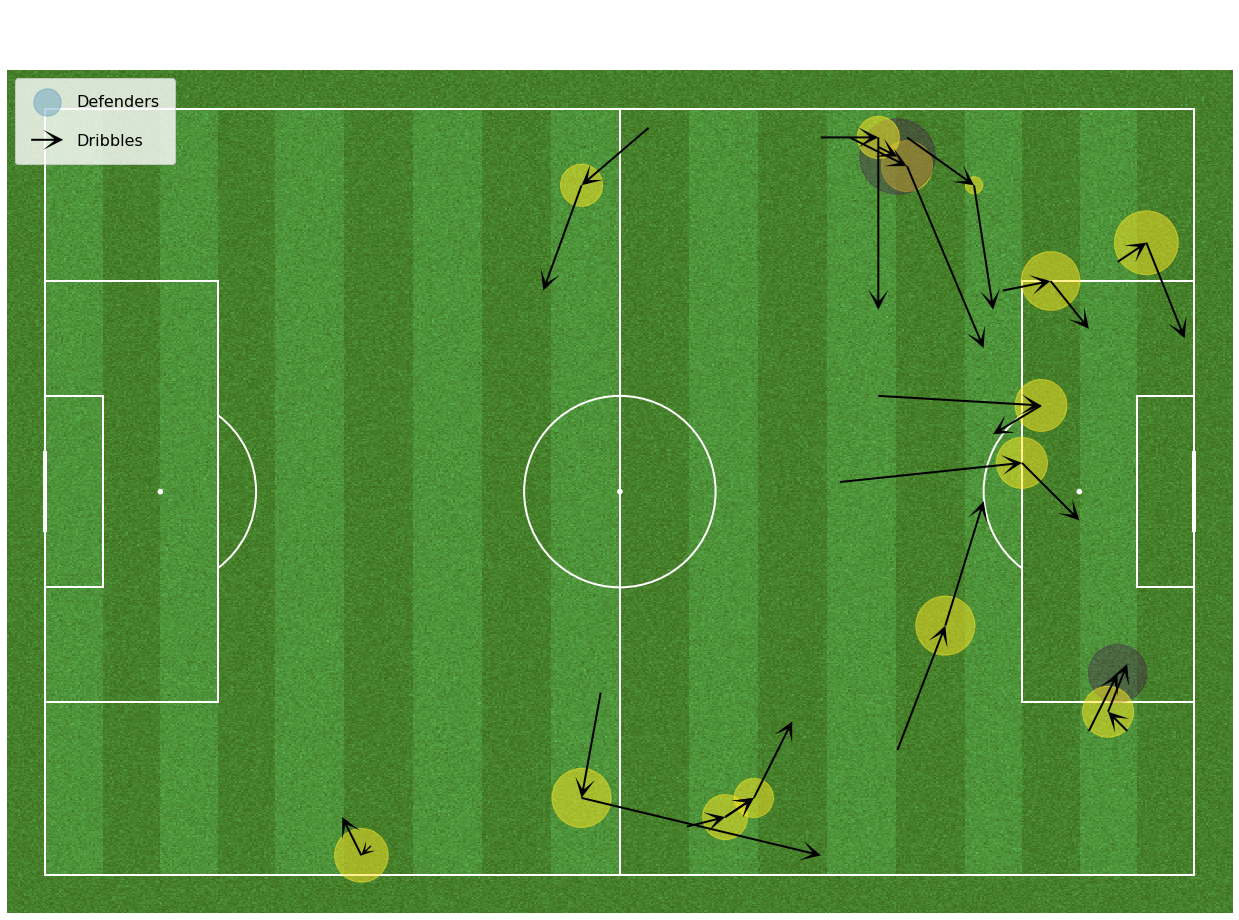

In [24]:
%%time

# Ante Rebić
# Neymar da Silva Santos Junior
# Francisco Román Alarcón Suárez
# Luka Modrić
# Lionel Andrés Messi Cuccittini

player_name = 'Ante Rebić'

plot_pitch(df_dribble_detail, lst_events, player_name)

CPU times: user 50.9 s, sys: 1.18 s, total: 52 s
Wall time: 46.1 s


,dribbleId,carryId,dribble_start_x,dribble_start_y,dribble_end_x,dribble_end_y,dribble_duration,team,dribbler,location_x,location_y,dribble_outcome,overrun_flag,nutmeg_flag,other_team,other_player,other_event,eloDribbler,eloDefender,dribbleProbability
0,6abf8fe4-03f1-4e38-9b07-f72f9bacf9ec,244298f6-aad2-45fb-ba35-236e47938951,59.0,58.0,66.0,40.0,5.280,Argentina,Lionel Andrés Messi Cuccittini,66.0,40.0,1,0,0,Iceland,Alfreð Finnbogason,Dribbled Past,199.729466,78.958910,0.667125
1,6abf8fe4-03f1-4e38-9b07-f72f9bacf9ec,d8b5d5a6-cdb3-4653-854a-b48517371aff,66.0,40.0,72.0,35.0,0.640,Argentina,Lionel Andrés Messi Cuccittini,66.0,40.0,1,0,0,Iceland,Alfreð Finnbogason,Dribbled Past,199.729466,78.958910,0.667125
2,d84fe3ff-2ea7-4abc-99f1-73f882fc8ec5,7548a5f9-70c6-46e0-a3bc-1695295b3acf,86.0,41.0,97.0,49.0,4.080,Argentina,Lionel Andrés Messi Cuccittini,97.0,49.0,0,1,0,Iceland,Emil Hallfreðsson,Dribbled Past,199.729466,83.592776,0.661175
3,7fe3f0fb-74ae-489e-8233-c1a7d943bcd8,0a2213aa-7d5c-4169-80f8-d2b3881af849,67.0,55.0,66.0,53.0,1.480,Argentina,Lionel Andrés Messi Cuccittini,66.0,53.0,0,0,1,Iceland,Aron Einar Gunnarsson,Duel,199.729466,81.906892,0.663346
4,35467eb3-3039-4339-9688-a90e7b966898,cd881a4c-dadf-4b33-8c3a-133510cc8a37,85.0,55.0,93.0,57.0,1.693,Argentina,Lionel Andrés Messi Cuccittini,93.0,57.0,0,0,0,Iceland,Kári Árnason,Duel,199.729466,90.434235,0.652298
5,96cc6d0c-4a85-493b-bf96-8cb57c6affca,cd881a4c-dadf-4b33-8c3a-133510cc8a37,85.0,55.0,93.0,57.0,1.693,Argentina,Lionel Andrés Messi Cuccittini,85.0,55.0,1,0,0,Iceland,Ragnar Sigurðsson,Dribbled Past,199.729466,102.060603,0.636968
6,cf853d82-1868-4e1e-be9e-2215b9086ada,fb680730-175e-4de1-9083-e49b255bc18d,74.0,49.0,101.0,41.0,3.853,Argentina,Lionel Andrés Messi Cuccittini,101.0,41.0,1,0,0,Iceland,Aron Einar Gunnarsson,Dribbled Past,199.729466,81.906892,0.663346
7,cf853d82-1868-4e1e-be9e-2215b9086ada,d40fe16c-041a-4d4a-9c80-6f55c92eead5,101.0,41.0,91.0,39.0,5.667,Argentina,Lionel Andrés Messi Cuccittini,101.0,41.0,1,0,0,Iceland,Aron Einar Gunnarsson,Dribbled Past,199.729466,81.906892,0.663346
8,cbfcbcc4-76d6-41eb-9bb7-80e1d2479fd1,f33d9497-8c66-4eae-b2f4-f247ced12bf3,98.0,55.0,97.0,51.0,1.333,Argentina,Lionel Andrés Messi Cuccittini,97.0,51.0,1,0,0,Iceland,Emil Hallfreðsson,Dribbled Past,199.729466,83.592776,0.661175
9,cbfcbcc4-76d6-41eb-9bb7-80e1d2479fd1,79830fcc-8833-445c-8f5f-f3d6996ebace,97.0,51.0,94.0,41.0,1.707,Argentina,Lionel Andrés Messi Cuccittini,97.0,51.0,1,0,0,Iceland,Emil Hallfreðsson,Dribbled Past,199.729466,83.592776,0.661175


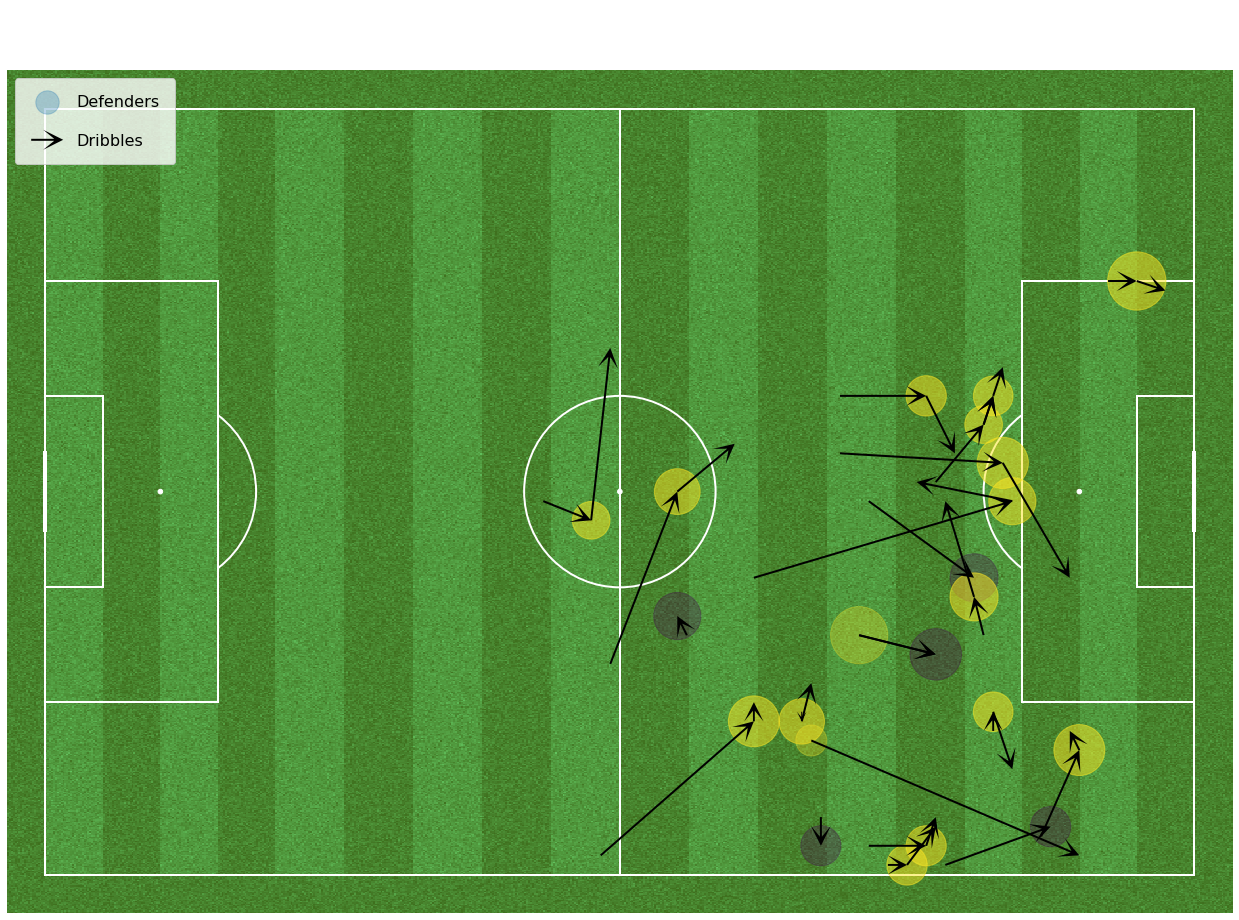

In [25]:
%%time

player_name = 'Lionel Andrés Messi Cuccittini'

plot_pitch(df_dribble_detail, lst_events, player_name)

In [41]:
shots = [j for i in lst_events for j in i if j.get('type').get('name') == 'Shot']


In [45]:
shots[3]

{'id': '0c739641-6e91-4e71-a84f-70376ff5d6a0',
 'index': 473,
 'period': 1,
 'timestamp': '00:10:49.680',
 'minute': 10,
 'second': 49,
 'type': {'id': 16, 'name': 'Shot'},
 'possession': 25,
 'possession_team': {'id': 796, 'name': 'Russia'},
 'play_pattern': {'id': 4, 'name': 'From Throw In'},
 'team': {'id': 796, 'name': 'Russia'},
 'player': {'id': 5180, 'name': 'Alan Dzagoev'},
 'position': {'id': 19, 'name': 'Center Attacking Midfield'},
 'location': [106.0, 49.0],
 'duration': 0.16,
 'related_events': ['5b317b5a-0020-48d6-8d76-7df3f8622e31',
  'f60937a8-f37b-4d5f-b8df-b2eedab80682'],
 'shot': {'statsbomb_xg': 0.07074226,
  'end_location': [107.0, 49.0],
  'key_pass_id': 'ebc110b2-ee6a-4b40-9390-e9863e24ef8d',
  'type': {'id': 87, 'name': 'Open Play'},
  'technique': {'id': 93, 'name': 'Normal'},
  'outcome': {'id': 96, 'name': 'Blocked'},
  'body_part': {'id': 40, 'name': 'Right Foot'},
  'freeze_frame': [{'location': [105.0, 36.0],
    'player': {'id': 5194, 'name': 'Fyodor Smol

In [46]:
gk = [j for i in lst_events for j in i if j.get('type').get('name') == 'Goal Keeper']



In [56]:
gk[4]

{'id': 'a9f5f43d-ad5c-4de6-b891-3a3253886b2c',
 'index': 490,
 'period': 1,
 'timestamp': '00:11:33.413',
 'minute': 11,
 'second': 33,
 'type': {'id': 23, 'name': 'Goal Keeper'},
 'possession': 26,
 'possession_team': {'id': 796, 'name': 'Russia'},
 'play_pattern': {'id': 2, 'name': 'From Corner'},
 'team': {'id': 799, 'name': 'Saudi Arabia'},
 'player': {'id': 5189, 'name': 'Abdullah Ibrahim Al Maiouf'},
 'position': {'id': 1, 'name': 'Goalkeeper'},
 'location': [2.0, 38.0],
 'related_events': ['be94c656-9952-4c0b-80fd-80772bd19c02'],
 'goalkeeper': {'position': {'id': 44, 'name': 'Set'},
  'type': {'id': 26, 'name': 'Goal Conceded'},
  'outcome': {'id': 55, 'name': 'No Touch'}}}

In [50]:
Counter([i.get('goalkeeper').get('type').get('name') for i in gk])

Counter({'Shot Faced': 1182,
         'Goal Conceded': 135,
         'Keeper Sweeper': 31,
         'Shot Saved': 326,
         'Collected': 143,
         'Punch': 84,
         'Smother': 5,
         'Penalty Conceded': 48,
         'Penalty Saved': 15,
         'Save': 6})

In [53]:
Counter([i.get('goalkeeper').get('position',{}).get('name') for i in gk])

Counter({'Set': 1525, None: 269, 'Moving': 142, 'Prone': 39})

In [57]:
Counter([i.get('goalkeeper').get('outcome',{}).get('name') for i in gk])

Counter({None: 1185,
         'No Touch': 168,
         'Claim': 16,
         'Success': 301,
         'In Play Danger': 71,
         'In Play Safe': 112,
         'Won': 2,
         'Touched Out': 57,
         'Touched In': 12,
         'Saved Twice': 21,
         'Clear': 15,
         'Fail': 8,
         'Collected Twice': 6,
         'Lost': 1})